In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil, os, random,cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold
from keras.layers.normalization import BatchNormalization

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1. Descargar y preparar conjunto de datos**

In [3]:
folder="../../../Dataset/GarciaLSB_Mono/"

In [4]:
images=os.listdir(folder)
random.shuffle(images)
print(len(images))

89560


### Orden aleatorio del dataset

In [5]:
import time
t = time.time()
x=np.array([ mpimg.imread(folder+images[i])/255.0  for i in range(len(images))],dtype=np.float32)
elapsed = time.time() - t
print(elapsed)

898.8631839752197


In [6]:
isStego=lambda x:1 if x[:6]=="stego_" else 0
getYFromImageList=lambda x: [isStego(element) for element in x]
y=np.array(getYFromImageList(images),dtype='float32')

### Obteniendo las categorías

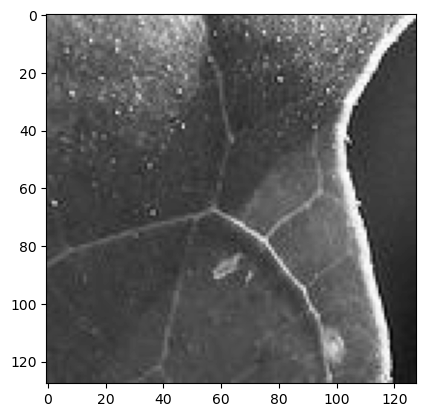

In [7]:
plt.imshow(mpimg.imread(folder+images[15]),cmap="gray")
plt.show()

### Obteniendo data de x

# Acá se usan 30GB de memoria (?) algo raro está pasando, de pronto hay que convertirlo a np array en otra línea. List comprehension usa mucha memoria...

In [8]:
import gc
gc.enable()
gc.garbage

[]

### Dividiendo entrenamiento y prueba

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(71648, 128, 128) (71648,)
(17912, 128, 128) (17912,)


In [10]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

#reshape data to fit model
X_train = X_train.reshape(71647,128,128,3)
X_test = X_test.reshape(17912,128,128,3)

# **3. Base Convolucional**

In [11]:
# Custom filter
def high_pass(shape, dtype=None):
    f = np.zeros(shape, dtype='float32')
    f[:,:,0,0] = np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')
    f/=12    
    return K.variable(f, dtype='float32')

In [13]:
#Setting early stopping
earlystopping=callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=20,restore_best_weights=True)
#Conv

model = models.Sequential()
model.add(layers.Conv2D(128,(5,5), padding='valid',strides=[1, 1],
                  input_shape=(128, 128,1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(BatchNormalization())
#Dense
model.add(layers.Flatten())#, activation='relu'
model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='softmax'))
#Comp
customSGD=tf.optimizers.SGD(learning_rate=0.015)
customAdam=tf.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy',f1_m,precision_m, recall_m])
    # Generate a print
print('------------------------------------------------------------------------')
#Fitting
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=200, callbacks=[earlystopping],batch_size=64)
gc.collect()
print("\n\n\n\n\nFitted")
#dataMqtt={"Fold":str(fold_no),"timestamp":str(datetime.now()),"Loss":str(test_loss), "Acc":str(test_acc),"F1":str(f1_score),"Precision":str( precision),"Recall": str(recal)}
#dataMqtt_out=json.dumps(data)
#retMqtt= client1.publish("stegian/data",dataMqtt_out)

gc.collect()

------------------------------------------------------------------------
Epoch 1/200
1120/1120 [==============================] - 9685s 9s/step - loss: 7.6290 - accuracy: 0.4997 - f1_m: 0.6639 - precision_m: 0.4997 - recall_m: 1.0000 - val_loss: 7.6067 - val_accuracy: 0.5012 - val_f1_m: 0.6655 - val_precision_m: 0.5012 - val_recall_m: 1.0000
Epoch 2/200
1120/1120 [==============================] - 9588s 9s/step - loss: 7.6290 - accuracy: 0.4997 - f1_m: 0.6642 - precision_m: 0.4997 - recall_m: 1.0000 - val_loss: 7.6067 - val_accuracy: 0.5012 - val_f1_m: 0.6655 - val_precision_m: 0.5012 - val_recall_m: 1.0000
Epoch 3/200
1120/1120 [==============================] - 9561s 9s/step - loss: 7.6290 - accuracy: 0.4997 - f1_m: 0.6642 - precision_m: 0.4997 - recall_m: 1.0000 - val_loss: 7.6067 - val_accuracy: 0.5012 - val_f1_m: 0.6655 - val_precision_m: 0.5012 - val_recall_m: 1.0000
Epoch 4/200
1120/1120 [==============================] - 9581s 9s/step - loss: 7.6290 - accuracy: 0.4997 - f1_m: 0

0

560/560 - 395s - loss: 7.6067 - accuracy: 0.5012 - f1_m: 0.6633 - precision_m: 0.5012 - recall_m: 1.0000
Loss: 7.60673189163208 
Accuracy: 0.5011724233627319 
F1 score: 0.6632599830627441 
Precision: 0.5011904835700989 
Recall 1.0


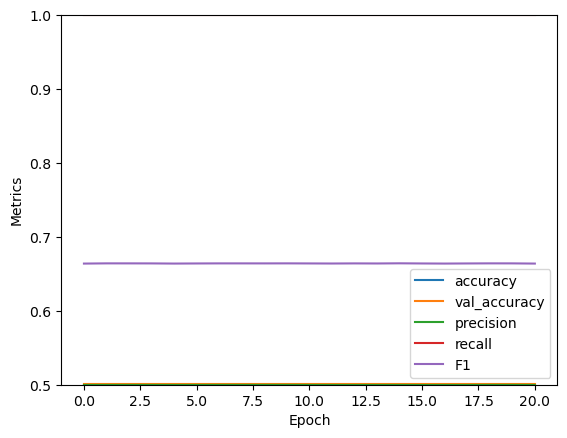

Next fold


In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc,f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=2)
print("Loss:",test_loss, "\nAccuracy:",test_acc,"\nF1 score:",f1_score, "\nPrecision:",precision, "\nRecall",recall)

plt.plot(history.history['precision_m'], label='precision')
plt.plot(history.history['recall_m'], label = 'recall')
plt.plot(history.history['f1_m'], label = 'F1')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend(loc='lower right')
plt.show()
print("Next fold")

In [15]:
# Generate generalization metrics
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Score for model: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


Score for model: loss of 7.60673189163208; accuracy of 50.11724233627319%


In [13]:
from scipy import ndimage
kernal=   np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')/12  
    
plt.imshow(ndimage.convolve(cover, kernal)-ndimage.convolve(stego, kernal),cmap='gray')#-ndimage.convolve(stego, kernal)
plt.show()

NameError: name 'cover' is not defined

In [16]:
gc.collect()

9059

# Acá también se usa mucha memoria

#model.build((None,128,128,3))
model.summary()

# **4. Agregar capas densas en la parte superior**

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 128)     3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 39, 512)       590336    
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 39, 512)       2048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 1024)      4

# **5. Compilar y entrenar el modelo**



In [19]:
#model.save("CNNv2_Mono_WOW5.h5")

# **6. Evaluar el modelo**